# Data Exploration and Statistical Analysis of OAI Dataset

## Project Overview
---

This project focuses on the analysis of the Osteoarthritis Initiative (OAI) dataset to explore participant data and perform statistical analysis, particularly using bootstrapping methods. It covers data processing, visualization, and two-sample hypothesis testing to understand potential differences in Kellgren-Lawrence (KL) grades across different demographic groups.

---
# Part 1: OAI Data Access and Initial Setup

This initial phase outlines the process of gaining access to the OAI dataset and setting up the necessary environment for data analysis. Access to the OAI dataset is essential for proceeding with subsequent data processing and analysis tasks.

---
# Part 2: Data Processing and Visualization

## Introduction to the OAI Dataset

### Osteoarthritis Initiative (OAI)

Osteoarthritis (OA) is a prevalent degenerative joint disease. The Osteoarthritis Initiative (OAI) is a multicenter, longitudinal, and prospective observational study focused on knee OA, aiming to understand its progression and risk factors.

<img src="https://runwayhealth.ca/wp-content/uploads/2021/06/knee-osteoarthritis-stages.jpg" width="700">

**Follow-Up Visit Schedule**

| Visit            | Baseline (0 month) | 12m       | 24m       | 36m       | 48m       | 72m       | 96m       |
|------------------|--------------------|-----------|-----------|-----------|-----------|-----------|-----------|
| **Visit ID**     | 00                 | 01        | 03        | 05        | 06        | 08        | 10        |
| **Clinic Visit** | 4,796 (subjects)   | 4,293     | 4,082     | 3,925     | 3,831     | 3,239     | 3,117     |
| **Percentage**   | 100%               | 90%       | 85%       | 82%       | 80%       | 68%       | 65%       |

The baseline visit is the starting point. Visit IDs map to durations from the baseline, e.g., `03` corresponds to 24 months.

### Dataset Structure

The project uses participant information and clinical data from:

- `Enrollees.txt`: Contains participant demographics like ID, sex, and acquisition site.
- `AllClinical<visit_id>.txt`: Clinical variables at different follow-up visits.
- `kxr_sq_bu<visit_id>.txt`: Knee OA x-ray biomarkers over time.

Data files are in CSV format using `|` as a separator.
```
ID|P02RACE|P02SEX|V00SITE|...
9000099|1: White or Caucasian|1: Male|B|...
9001104|1: White or Caucasian|2: Female|D|...
...
```

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Path to the root directory of the OAI data
metadata_root = Path('./OAICompleteData_ASCII')

### Task 1: Exploring Participant Demographics


#### Task 1.1: Creating a Participant Dataframe

Extract participant information (ID, sex, and acquisition site) from `Enrollees.txt` to create a Pandas DataFrame with columns `ID`, `Sex`, and `Site`.

In [2]:
def extract_participant_data(metadata_root: Path) -> pd.DataFrame:
    # Read the Enrollees.txt file
    df = pd.read_csv(metadata_root / 'Enrollees.txt', sep='|')
    # Select the required columns and rename them
    df = df[['ID', 'P02SEX', 'V00SITE']]
    df.columns = ['ID', 'Sex', 'Site']
    # Map the sex values
    df['Sex'] = df['Sex'].map({'1: Male': 'Male', '2: Female': 'Female'})
    return df
df_participants = extract_participant_data(metadata_root)
df_participants

,ID,Sex,Site
0,9000099,Male,B
1,9000296,Male,D
2,9000622,Female,B
3,9000798,Male,D
4,9001104,Female,B
...,...,...,...
4791,9999365,Male,B
4792,9999510,Male,E
4793,9999862,Female,D
4794,9999865,Female,B


#### Task 1.2: Counting Participants by Demographics

Implement functions to count participants based on sex and acquisition site, returning dictionaries of counts.

In [3]:
def count_participants_by_sex(df: pd.DataFrame) -> dict:
    # Count the number of participants by sex
    return df['Sex'].value_counts().to_dict()

def count_participants_by_site(df: pd.DataFrame) -> dict:
    # Count the number of participants by site
    return df['Site'].value_counts().to_dict()

count_by_sex = count_participants_by_sex(df_participants)
count_by_site = count_participants_by_site(df_participants)
print(count_by_sex)
print(count_by_site)

{'Female': 2804, 'Male': 1992}
{'C': 1306, 'D': 1173, 'B': 1000, 'A': 756, 'E': 561}


### Task 2: Longitudinal Dataframe Creation

#### Task 2.1: Loading Clinical Data

Combine clinical data files `AllClinical<visit_id>.txt` for visits `'00', '01', '03', '05', '06', '08', '10'` into a longitudinal dataframe. Load clinical data at each specified follow-up visit, structuring the output dataframe to include `ID`, `Visit`, `Age`, and `BMI` columns.

In [4]:
follow_ups = ['00', '01', '03', '05', '06', '08', '10']
visit_map = {'00': 0, '01': 12, '03': 24, '05': 36, '06': 48, '08': 72, '10': 96}

def load_clinical_data(metadata_root: Path, visit_id: str) -> pd.DataFrame:
    file_path = metadata_root / f"AllClinical{visit_id}.txt"
    df = pd.read_csv(file_path, sep='|')
    
    if visit_id == '00':
        df = df.rename(columns={f'V{visit_id}AGE': 'Age', f'P01BMI': 'BMI'})
    else:
        df = df.rename(columns={f'V{visit_id}AGE': 'Age', f'V{visit_id}BMI': 'BMI'})
    
    df['Visit'] = visit_map[visit_id]
    return df[['ID', 'Visit', 'Age', 'BMI']]

def load_all_clinical_data(metadata_root: Path) -> pd.DataFrame:
    df_list = []
    for visit_id in follow_ups:
        df = load_clinical_data(metadata_root, visit_id)
        df_list.append(df)
    
    df_all = pd.concat(df_list, ignore_index=True)
    return df_all

# Call the function to load all clinical data
df_clinical_data = load_all_clinical_data(metadata_root)
df_clinical_data

,ID,Visit,Age,BMI
0,9000099,0,59.0,23.8
1,9000296,0,69.0,29.8
2,9000622,0,71.0,22.7
3,9000798,0,56.0,32.4
4,9001104,0,72.0,30.7
...,...,...,...,...
33567,9999365,96,64.0,33.5
33568,9999510,96,58.0,30.4
33569,9999862,96,69.0,23.7
33570,9999865,96,69.0,26.0


#### Task 2.2: Merging Participant and Clinical Data

Merge `df_participants` and `df_clinical_data` using a right join based on `ID` to combine demographic and clinical information into a single dataframe.

In [5]:
def right_join_participants_clnical_data(df_participants: pd.DataFrame, df_clinical_data: pd.DataFrame) -> pd.DataFrame:
    # Perform right join on 'ID'
    df_merged = pd.merge(df_clinical_data, df_participants, on='ID', how='right')
    return df_merged[['ID', 'Visit', 'Age', 'BMI', 'Sex', 'Site']]

df_participants_clinical_data = right_join_participants_clnical_data(df_participants, df_clinical_data)
df_participants_clinical_data

,ID,Visit,Age,BMI,Sex,Site
0,9000099,0,59.0,23.8,Male,B
1,9000099,12,60.0,24.1,Male,B
2,9000099,24,61.0,23.4,Male,B
3,9000099,36,62.0,23.7,Male,B
4,9000099,48,63.0,24.7,Male,B
...,...,...,...,...,...,...
33567,9999878,24,74.0,28.0,Female,C
33568,9999878,36,75.0,28.5,Female,C
33569,9999878,48,76.0,27.7,Female,C
33570,9999878,72,77.0,29.7,Female,C


#### Task 2.3: Loading Kellgren and Lawrence (KL) Grades

Load KL grades from `kxr_sq_bu<visit_id>.txt` files for all visits into a dataframe. This dataframe should contain `ID`, `Visit`, `Side`, and `KL` grade, with knee side differentiated and visit IDs mapped to visit durations.

In [6]:
def load_kls_grades(metadata_root: Path, visit_id: str) -> pd.DataFrame:
    file_path = metadata_root / f"kxr_sq_bu{visit_id}.txt"
    df = pd.read_csv(file_path, sep='|')
    
    if visit_id == '05':
        df = df.rename(columns={f'v{visit_id}XRKL': 'KL'})
    else:
        df = df.rename(columns={f'V{visit_id}XRKL': 'KL'})
    
    df = df.rename(columns={'SIDE': 'Side'})
    df['Side'] = df['Side'].map({1: 'R', 2: 'L'})
    df['Visit'] = visit_map[visit_id]
    
    return df[['ID', 'Side', 'KL', 'Visit']]

def load_all_kl_grades(metadata_root: Path) -> pd.DataFrame:
    df_list = []
    for visit_id in follow_ups:
        df = load_kls_grades(metadata_root, visit_id)
        df_list.append(df)
    
    df_all = pd.concat(df_list, ignore_index=True)
    return df_all

# Call the function to load all KL grades data
df_kl_grades = load_all_kl_grades(metadata_root)
df_kl_grades

,ID,Side,KL,Visit
0,9000099,R,2.0,0
1,9000099,L,3.0,0
2,9000296,R,2.0,0
3,9000296,L,3.0,0
4,9000622,R,1.0,0
...,...,...,...,...
55190,9999365,L,4.0,96
55191,9999510,R,3.0,96
55192,9999865,R,0.0,96
55193,9999865,L,2.0,96


#### Task 2.4: Integrating KL Grades with Clinical Data

Merge `df_participants_clinical_data` and `df_kl_grades` to include KL grades in the clinical data. Use an inner join for merging, and explain the reason for choosing this type of join.

In [7]:
def join_clinical_data_with_kl_grades(df_participants_clinical_data: pd.DataFrame, df_kl_grades: pd.DataFrame) -> pd.DataFrame:
    # Perform inner join on 'ID' and 'Visit'
    df_merged = pd.merge(df_participants_clinical_data, df_kl_grades, on=['ID', 'Visit'], how='inner')
    return df_merged[['ID', 'Side', 'KL', 'Visit', 'Age', 'BMI', 'Sex', 'Site']]

df_master = join_clinical_data_with_kl_grades(df_participants_clinical_data, df_kl_grades)
df_master

# Explanation of the choice (b)
# An inner join is chosen to retain only records with matched IDs and Visits in both clinical data and KL grades datasets,
# ensuring data integrity for subsequent analyses.

,ID,Side,KL,Visit,Age,BMI,Sex,Site
0,9000099,R,2.0,0,59.0,23.8,Male,B
1,9000099,L,3.0,0,59.0,23.8,Male,B
2,9000099,R,2.0,12,60.0,24.1,Male,B
3,9000099,L,4.0,12,60.0,24.1,Male,B
4,9000099,R,2.0,24,61.0,23.4,Male,B
...,...,...,...,...,...,...,...,...
55190,9999878,R,2.0,48,76.0,27.7,Female,C
55191,9999878,L,1.0,48,76.0,27.7,Female,C
55192,9999878,L,1.0,48,76.0,27.7,Female,C
55193,9999878,L,1.0,72,77.0,29.7,Female,C


#### Task 2.5: Dataframe Pivoting and Unpivoting

(a) Pivot `df_master` to organize KL grades by visit, with each row representing a unique participant knee (defined by ID and Side).

(b) Unpivot `df_master_pivot` back to a long format using the `melt` function.

In [8]:
def pivot_dataframe(df_master: pd.DataFrame) -> pd.DataFrame:
    # Pivot the dataframe to have visits as columns, using mean to handle duplicates
    df_pivot = df_master.pivot_table(index=['ID', 'Side', 'Sex', 'Site'], columns='Visit', values='KL', aggfunc='mean').reset_index()
    df_pivot.columns.name = None  # Remove the name of the columns index
    return df_pivot

def unpivot_dataframe(df_master_pivot: pd.DataFrame) -> pd.DataFrame:
    # Unpivot the dataframe to have a long format
    df_unpivot = df_master_pivot.melt(id_vars=['ID', 'Side', 'Sex', 'Site'], var_name='Visit', value_name='KL')
    df_unpivot['Visit'] = df_unpivot['Visit'].astype(int)  # Ensure Visit is of type int
    return df_unpivot

df_master_pivot = pivot_dataframe(df_master)
df_master_pivot

df_master_unpivot = unpivot_dataframe(df_master_pivot)
df_master_unpivot

,ID,Side,Sex,Site,Visit,KL
0,9000099,L,Male,B,0,3.0
1,9000099,R,Male,B,0,2.0
2,9000296,L,Male,D,0,3.0
3,9000296,R,Male,D,0,2.0
4,9000622,L,Female,B,0,1.0
...,...,...,...,...,...,...
62687,9999862,R,Female,D,96,NaN
62688,9999865,L,Female,B,96,2.0
62689,9999865,R,Female,B,96,0.0
62690,9999878,L,Female,C,96,1.0


In [9]:
df_master['Visit'].sample(10)

35699    24
50381     0
36224     0
13637    48
37170    36
24807    48
52931    48
2805      0
44542    12
26357    36
Name: Visit, dtype: int64

## Task 3: Data Visualization

#### Task 3.1: Visualizing Participant Distribution by Site

Create a bar chart to display the number of participants per acquisition site using `count_by_site` from Task 1.2.

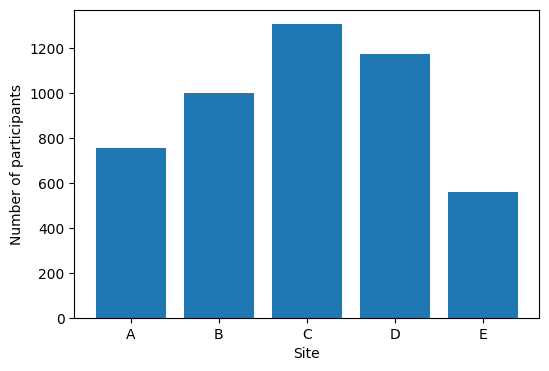

In [10]:
def plot_count_by_site(count_by_site: dict):
    # Set the figure size
    plt.figure(figsize=(6, 4))
    
    # Create a bar chart
    sites = ['A', 'B', 'C', 'D', 'E']
    counts = [count_by_site[site] for site in sites]
    plt.bar(sites, counts)
    
    # Label the axes
    plt.xlabel('Site')
    plt.ylabel('Number of participants')
    
    # Show the plot
    plt.show()

plot_count_by_site(count_by_site=count_by_site)

#### Task 3.2: Box Plot of KL Grade vs. BMI at Baseline

Generate a box plot to illustrate the relationship between KL grades and BMI at the baseline visit (Visit 0), using baseline records from `df_master`.

C:\Users\SATAS\AppData\Local\Temp\ipykernel_7436\778931099.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='KL', y='BMI', data=df_baseline, palette='Set2')


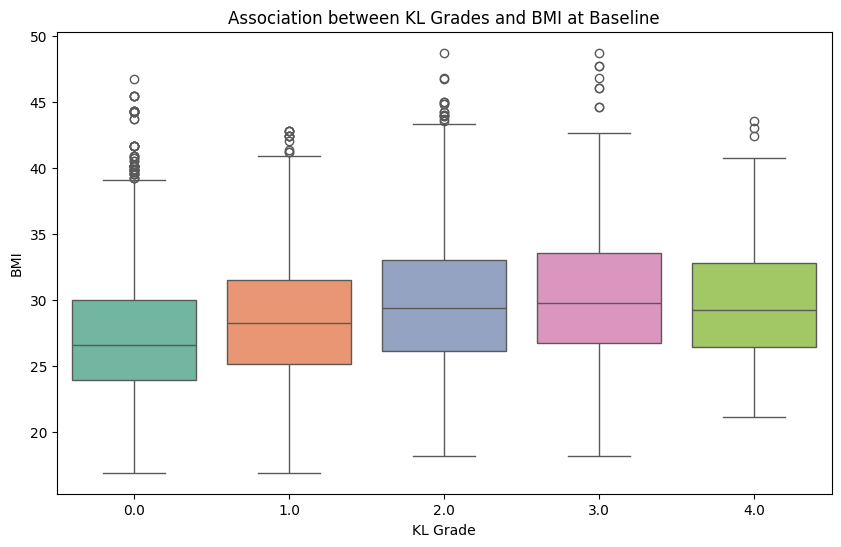

In [11]:
# Filter the dataframe to include only records at baseline (visit 0)
df_baseline = df_master[df_master['Visit'] == 0]

def plot_kl_vs_bmi(df_baseline: pd.DataFrame):
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Create a box plot with different colors for each KL grade
    sns.boxplot(x='KL', y='BMI', data=df_baseline, palette='Set2')
    
    # Label the axes
    plt.xlabel('KL Grade')
    plt.ylabel('BMI')
    
    # Set the title
    plt.title('Association between KL Grades and BMI at Baseline')
    
    # Show the plot
    plt.show()

plot_kl_vs_bmi(df_baseline)

#### Task 3.3: Visualizing KL Grade Trends Over Time by Site

Create a line plot to visualize KL grade trends over follow-up visits, segmented by acquisition site. This visualization should include confidence intervals to represent variability.

C:\Users\SATAS\AppData\Local\Temp\ipykernel_7436\1558087697.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='Visit', y='KL', hue='Site', data=df_master, ci=95, n_boot=1000, palette='Set1')


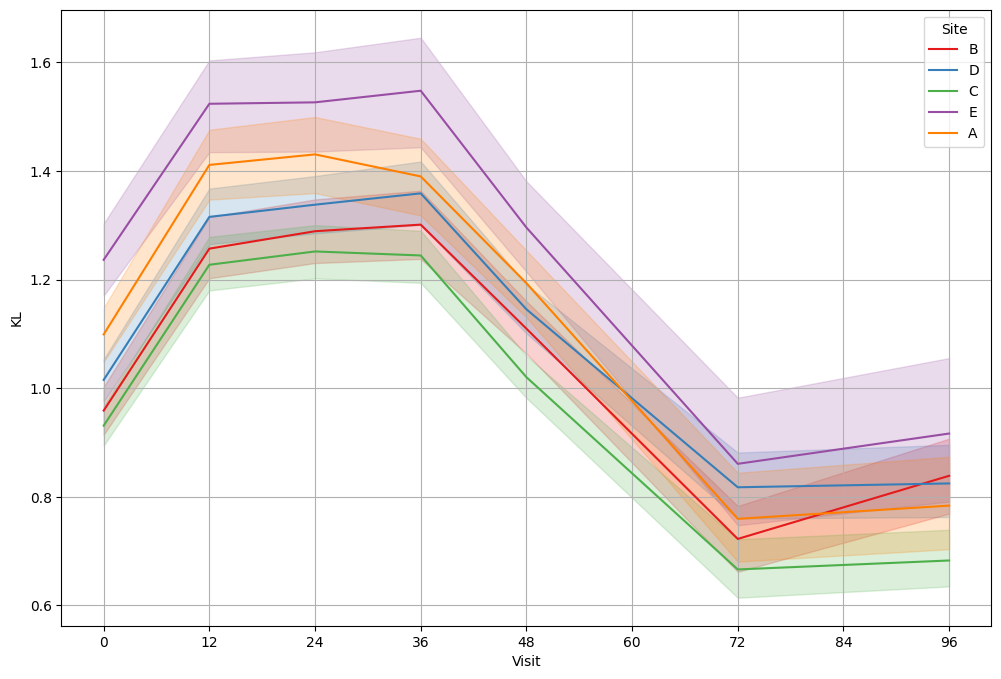

In [12]:
def plot_kl_trend(df_master: pd.DataFrame):
    # Set the figure size
    plt.figure(figsize=(12, 8))
    
    # Create a line plot with seaborn
    sns.lineplot(x='Visit', y='KL', hue='Site', data=df_master, ci=95, n_boot=1000, palette='Set1')
    
    # Label the axes
    plt.xlabel('Visit')
    plt.ylabel('KL')
    
    
    # Add grid
    plt.grid(True)
    
    # Set x-axis ticks to be only numbers divisible by 12
    plt.xticks(ticks=[i for i in range(0, df_master['Visit'].max() + 1, 12)])
    
    # Show the plot
    plt.show()

plot_kl_trend(df_master)

---
# Part 3: Two-Sample Tests

#### **Important Notes:**
- `assert()` statements are used to verify the correctness of the results.
- Focus on implementing code within *Write your code here* sections.

---
### **Task 1: Data Extraction and Bootstrapping**

This section focuses on extracting relevant data and applying bootstrapping techniques for statistical analysis.

---
### **Task 1.1: Data Extraction for Groups 1 and 2**

Extract data for Group 1 (female participants aged 60 and over) and Group 2 (male participants aged 60 and over), focusing on KL grades, and prepare NumPy arrays for bootstrapping.

(19745,)
(13391,)
Mean KL grade from group 1 (female, age >= 60): 1.2722208153963028
Mean KL grade from group 2 (male, age >= 60): 1.285340900604884
Task passed!


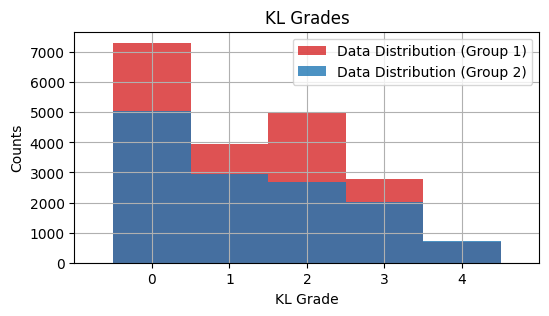

In [14]:
#Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

# Load data (remember to save OAI_data.csv to same location where Assignment_3.ibynb is located). 
csv_path = Path('./OAI_data.csv')
df_OAI = pd.read_csv(csv_path)  


# Function to visualize histograms
def visualize_histograms(data_group_1, data_group_2, x_label, y_label, title):    
    # Figure size 
    plt.figure(figsize=(6, 3))

    # Shift bin edges for better visualization (There are 5 Kl grades and they range from 0 to 4)
    bins = np.arange(6) - 0.5
    plt.xticks(range(5))
    plt.xlim([-1, 5])
    
    # Plot histogram
    plt.hist(data_group_1, bins=bins, alpha=0.8, color='tab:red', label="Data Distribution (Group 1)")
    plt.hist(data_group_2, bins=bins, alpha=0.8, color='tab:blue', label="Data Distribution (Group 2)")
    
    # Set title, labels, legend and grid for better visualization 
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)

# Function to visualize histograms with confidence intervals
def visualize_histogram_with_confidence_intervals(histogram_data, ci_lower, ci_upper, title):    
    # Figure size 
    plt.figure(figsize=(6, 3))

    # Plot histogram
    plt.hist(histogram_data, bins=50, alpha=0.6, color='c', label="Data Distribution")

    # Plot lower bound and upper bound
    plt.axvline(x=ci_lower, color='b', linestyle='-.', label="Lower Bound")
    plt.axvline(x=ci_upper, color='r', linestyle='-.', label="Upper Bound")
    plt.axvline(x=np.mean(histogram_data), color='black', linestyle='-.', label="Mean")

    # Set title, labels, legend and grid for better visualization 
    plt.title(f"KL Grade Differences with Confidence Intervals ({title})")
    plt.xlabel("Difference Between KL Grades")
    plt.ylabel("Counts")
    plt.legend()
    plt.grid(True) 

# Function to visualize one histogram
def visualize_histogram(bootstrap_theta, title):
    # Figure size 
    plt.figure(figsize=(6, 4))
    
    # Plot histogram
    plt.hist(bootstrap_theta, bins=50, alpha=0.8, color='tab:blue')
    plt.title(r'Histogram of the test statistics $\hat{\theta}$')
    plt.show()
    plt.close() 
    
# ------------ Project Code:  
group_1 = df_OAI[(df_OAI['Age'] >= 60) & (df_OAI['Sex'] == 'Female')]['KL'].dropna().to_numpy()
group_2 = df_OAI[(df_OAI['Age'] >= 60) & (df_OAI['Sex'] == 'Male')]['KL'].dropna().to_numpy()

# ------------

print(group_1.shape)
print(group_2.shape)

print(f'Mean KL grade from group 1 (female, age >= 60): {group_1.mean()}')
print(f'Mean KL grade from group 2 (male, age >= 60): {group_2.mean()}')

# Assertion checks
assert group_1.shape == (19745,)
assert group_2.shape == (13391,)
assert np.round(group_1.mean(), 3) == np.round(1.2722208153963028, 3)
assert np.round(group_2.mean(), 3) == np.round(1.285340900604884, 3)
print('Task passed!')

# Data distribution visualization
visualize_histograms(group_1, group_2, x_label = "KL Grade", y_label = "Counts", title = 'KL Grades')

---
### **Task 1.2: Implementing Bootstrap Sampling (Two Groups)**

Implement the `bootstrap_sampling()` function to resample data with replacement and compute test statistics (mean difference) to compare Group 1 and Group 2.

The mean of bootstrap_theta is: -0.013225729948411208


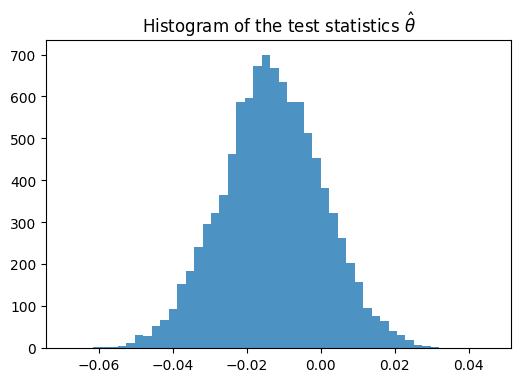

In [ ]:
def bootstrap_sampling(group_1: np.ndarray, group_2: np.ndarray, n_bootstraps: int) -> np.ndarray:
    
    # Set seed for reproducibility    
    np.random.seed(42)      

    # Initialize 'result' list
    result = [] 
    
         
    for _ in range(n_bootstraps):
        resampled_group_1 = np.random.choice(group_1, size=len(group_1), replace=True)
        resampled_group_2 = np.random.choice(group_2, size=len(group_2), replace=True)
        result_from_resampled_group_1 = np.mean(resampled_group_1)
        result_from_resampled_group_2 = np.mean(resampled_group_2)
        result.append((result_from_resampled_group_1, result_from_resampled_group_2))
    
    result = np.array(result)
    computed_test_statistic = result[:, 0] - result[:, 1]
    
    # Assertion check
    assert computed_test_statistic.shape == (n_bootstraps,) 

    return computed_test_statistic 


# Number of bootstrap samples
n_bootstraps = 10000  

# Compute bootstrap statistics
test_stats = bootstrap_sampling(group_1 = group_1, group_2 = group_2, n_bootstraps = n_bootstraps)
bootstrap_theta = test_stats 
print(f'The mean of bootstrap_theta is: {bootstrap_theta.mean()}')  

# Assertion check
assert np.round(np.mean(bootstrap_theta), 3) == np.round(-0.013225729948411208, 3)

# Histogram visualization
visualize_histogram(bootstrap_theta = bootstrap_theta, title = r'Histogram of the test statistics $\hat{\theta}$')

---
### **Task 2: Confidence Interval Estimation via Bootstrapping**

Estimate 95% Confidence Intervals (CIs) using bootstrapping for the difference in KL grades between Group 1 and Group 2, utilizing both naïve percentile and more accurate normal distribution methods.

---
### **Task 2.1: Naïve 95% Confidence Intervals (CI) via Percentiles**

Implement the `naive_ci_via_percentiles()` function to calculate 95% CIs using the percentile method, directly using percentiles from the bootstrap distribution.

The ci_lower is: -0.0402515137792531
The ci_upper is: 0.013691006263698258


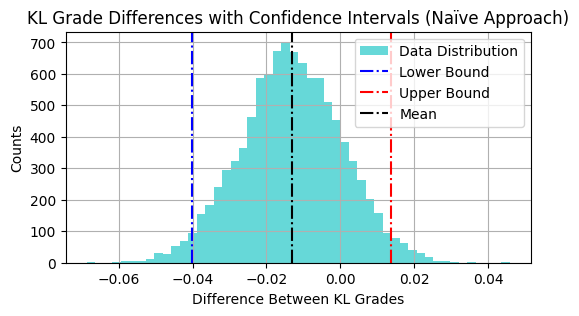

In [18]:
def naive_ci_via_percentiles(bootstrap_theta: np.ndarray, alpha_value: float) -> tuple:

    
    lower_percentile = alpha_value / 2
    upper_percentile = 1 - (alpha_value / 2)
    lower_bound = np.percentile(bootstrap_theta, lower_percentile * 100)
    upper_bound = np.percentile(bootstrap_theta, upper_percentile * 100)
    

    return lower_bound, upper_bound


alpha = 0.05
ci_lower, ci_upper = naive_ci_via_percentiles(bootstrap_theta=bootstrap_theta, alpha_value=alpha)

print(f'The ci_lower is: {ci_lower}')
print(f'The ci_upper is: {ci_upper}')

# Assertion checks
assert np.round(ci_lower, 3) == np.round(-0.0402515137792531, 3)
assert np.round(ci_upper, 3) == np.round(0.013691006263698258, 3)


# CI visualization
visualize_histogram_with_confidence_intervals(histogram_data = bootstrap_theta, ci_lower = ci_lower, 
                                              ci_upper = ci_upper, title = 'Naïve Approach')

---
### **Task 2.2: More Accurate 95% Confidence Interval (CI) Estimation**

Implement `normal_dist_ci()` and `compute_theta_hat()` functions to estimate a more accurate 95% CI using the normal distribution approximation method, suitable for normally distributed data.

The theta_hat is: -0.0131200852085811
better_ci_lower: -0.03993117668086046
better_ci_upper: 0.014011343362090901


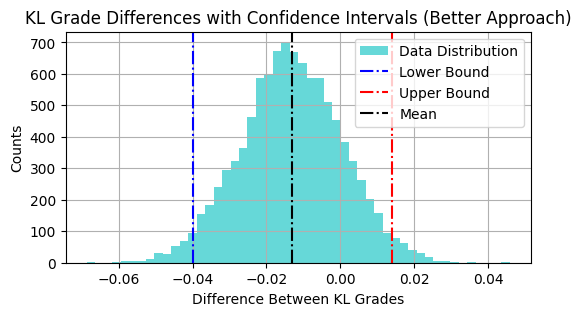

In [19]:
def compute_theta_hat(group_1: np.ndarray, group_2: np.ndarray) -> float:

    
    theta_hat_value = np.mean(group_1) - np.mean(group_2)

     
    
    return theta_hat_value

def normal_dist_ci(theta_hat: float, bootstrap_theta: np.ndarray, alpha_value: float) -> tuple:

    
    lower_percentile = alpha_value / 2
    upper_percentile = 1 - (alpha_value / 2)
    lower_bound = 2 * theta_hat - np.percentile(bootstrap_theta, upper_percentile * 100)
    upper_bound = 2 * theta_hat - np.percentile(bootstrap_theta, lower_percentile * 100)
    
    
    return lower_bound, upper_bound

alpha = 0.05
theta_hat = compute_theta_hat(group_1, group_2) 
better_ci_lower, better_ci_upper = normal_dist_ci(theta_hat = theta_hat, bootstrap_theta = bootstrap_theta, alpha_value = alpha)

print(f'The theta_hat is: {theta_hat}')
print(f'better_ci_lower: {better_ci_lower}')
print(f'better_ci_upper: {better_ci_upper}')

# Assertion checks
assert np.round(theta_hat, 3) == np.round(-0.0131200852085811, 3)
assert np.round(better_ci_lower, 3) == np.round(-0.03993117668086046, 3)
assert np.round(better_ci_upper, 3) == np.round(0.014011343362090901, 3)   


# CI visualization
visualize_histogram_with_confidence_intervals(histogram_data = bootstrap_theta, ci_lower = better_ci_lower, 
                                              ci_upper = better_ci_upper, title = "Better Approach")

---
### **Task 3: Hypothesis Testing for KL Grade Comparison**

Perform a two-sample test via bootstrapping to assess the statistical significance of KL grade differences between men and women in the age group of 60 years and older.

---
#### **Task 3.1: Computing Two-Sided P-value**
Implement the `compute_p_value()` function to calculate the two-sided p-value for the metric difference, using the bootstrapped test statistics.

In [20]:
def compute_p_value(test_stats: np.ndarray, observed: np.ndarray, n_bootstraps: int) -> float:

     
    null_distribution = test_stats - observed
    m = np.sum(np.abs(null_distribution) >= np.abs(observed))
    F_Z_hat_z = (m + 1) / (n_bootstraps + 1)
    p_two_sided = 2 * min(F_Z_hat_z, 1 - F_Z_hat_z)
    
    

    return p_two_sided

# Compute two-sided p-value
p_val_two_sided = compute_p_value(test_stats=bootstrap_theta, observed=theta_hat, n_bootstraps=n_bootstraps)

print(f'Two-sided p-value: {p_val_two_sided}')

Two-sided p-value: 0.6719328067193281


---
#### **Task 3.2: Conclusion based on P-value**

State the conclusion regarding the null hypothesis based on the computed p-value. Determine whether to reject or fail to reject the null hypothesis, and interpret the findings in the context of KL grade differences between genders.

Based on the analysis, we fail to reject the null hypothesis.
This suggests that there is no significant difference in KL grades
between men and women in the specified age group.


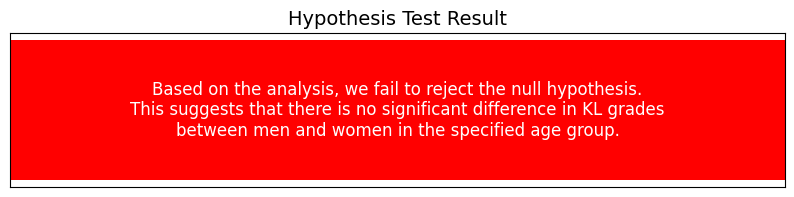

In [21]:
import matplotlib.pyplot as plt

# Project Conclusion
if p_val_two_sided < alpha:
    result_text = ("Based on the analysis, we reject the null hypothesis.\n"
                   "This indicates that there is a significant difference in KL grades\n"
                   "between men and women in the specified age group.")
    result_color = 'green'
else:
    result_text = ("Based on the analysis, we fail to reject the null hypothesis.\n"
                   "This suggests that there is no significant difference in KL grades\n"
                   "between men and women in the specified age group.")
    result_color = 'red'

print(result_text)

# Result visualization
fig, ax = plt.subplots(figsize=(10, 2))
ax.barh(['Result'], [2], color=result_color, height=1)
ax.set_xlim(0, 2)
ax.set_yticks([])
ax.set_xticks([])
ax.text(1, 0, result_text, ha='center', va='center', fontsize=12, color='white', wrap=True)
ax.set_title('Hypothesis Test Result', fontsize=14)
plt.show()

---